In [ ]:
# -*- coding: utf-8 -*-
"""
Versão consolidada e aprimorada dos modelos de precificação por RL.

Este script combina as seguintes características:
- Ações Contínuas: A IA pode recomendar qualquer preço dentro de uma faixa, em vez de escolher de uma lista fixa.
- Tiers de Produto: O modelo considera se o produto é 'Low', 'Mid' ou 'High Ticket' para otimizar o preço.
- Q-Function Avançada: Utiliza IQNQFunctionFactory para uma melhor modelagem da incerteza e do risco.
- Avaliação Robusta com Explicações: Inclui o cálculo da métrica FQE e comentários detalhados sobre as principais técnicas de Off-Policy Evaluation.
"""

# --- Etapa 1: Instalando e importando bibliotecas ---
print("--- Etapa 1: Instalando e importando bibliotecas ---")
!pip install openpyxl -q
!pip install d3rlpy --upgrade -q
import torch
import pandas as pd
import numpy as np
import kagglehub
import os
from collections import defaultdict
import d3rlpy
from d3rlpy.models import IQNQFunctionFactory
from d3rlpy.algos import CQLConfig
import matplotlib.pyplot as plt


--- Etapa 1: Instalando e importando bibliotecas ---
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 6.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.1/201.1 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [ ]:
# --- Etapa 2: Carregamento e preparação inicial dos dados ---
print("\n--- Etapa 2: Carregando e preparando os dados ---")
# Baixar o dataset
path = kagglehub.dataset_download("aashwinkumar/ppc-campaign-performance-data")
csv_file_path = os.path.join(path, "ppc_campaign_performance_data.xlsx")

# Carregar o dataset
try:
    df = pd.read_excel(csv_file_path)
    print("\nSUCESSO! Dataset carregado.")
except Exception as e:
    print(f"\nOcorreu um erro: {e}")
    exit()

# Pré-processamento inicial
df.dropna(inplace=True)
if 'budget' in df.columns:
    df.rename(columns={'budget': 'Budget'}, inplace=True)

# Converter a coluna numérica 'Budget' em categorias
bins = [0, 7500, 9000, float('inf')]
labels = ['Baixo', 'Médio', 'Alto']
df['Budget_Category'] = pd.cut(df['Budget'], bins=bins, labels=labels, right=False)
print("\nOrçamentos numéricos ('Budget') convertidos para categorias ('Budget_Category').")
# [Final da Célula da Etapa 2]
# ... (código que cria Budget_Category) ...
print(f"Coluna 'Budget_Category' criada? {'Budget_Category' in df.columns}")
print("Primeiras linhas com a nova coluna:")
print(df[['Budget', 'Budget_Category']].head())



--- Etapa 2: Carregando e preparando os dados ---


100%|██████████| 107k/107k [00:00<00:00, 10.5MB/s]

Extracting files...



SUCESSO! Dataset carregado.

Orçamentos numéricos ('Budget') convertidos para categorias ('Budget_Category').
Coluna 'Budget_Category' criada? True
Primeiras linhas com a nova coluna:
   Budget Budget_Category
0    6390           Baixo
1    9870            Alto
2    7700           Médio
3    8420           Médio
4    8470           Médio


In [ ]:
# --- Etapa 3: Geração do ambiente sintético para RL (Corrigido) ---
import pandas as pd
import numpy as np
from collections import defaultdict

print("\n--- Etapa 3: Gerando o ambiente sintético para o treinamento ---")

# --- Parte 1: Cálculos Iniciais (Executados uma vez) ---
print("Calculando métricas base (CPA, Conversion Rate)...")

# **CORREÇÃO: Garantir que Spend e Conversions são numéricos**
# Coerce errors to NaN, then fill NaNs perhaps? Or drop rows? Let's fill with 0 for now.
df['Spend'] = pd.to_numeric(df['Spend'], errors='coerce').fillna(0)
df['Conversions'] = pd.to_numeric(df['Conversions'], errors='coerce').fillna(0)
df['Clicks'] = pd.to_numeric(df['Clicks'], errors='coerce').fillna(0)
df['Impressions'] = pd.to_numeric(df['Impressions'], errors='coerce').fillna(0)


# Calcular CPA e CR
df['CPA'] = df['Spend'] / (df['Conversions'] + 1e-6)
df['Conversion_Rate'] = df['Clicks'] / (df['Impressions'] + 1e-6) # Ou Conversions/Clicks

# **CORREÇÃO: Limpar CPAs infinitos ou NaN antes de agrupar**
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Opcional: decidir o que fazer com NaNs em CPA (dropar a linha ou fillna?)
# df.dropna(subset=['CPA'], inplace=True) # Opção 1: Remover linhas com CPA inválido
df['CPA'].fillna(df['CPA'].median(), inplace=True) # Opção 2: Preencher com a mediana
df['Conversion_Rate'].fillna(df['Conversion_Rate'].median(), inplace=True)

# Calcular métricas regionais (agora sobre dados limpos)
region_metrics = df.groupby('Region').agg(
    avg_conversion_rate=('Conversion_Rate', 'mean'),
    avg_cpa=('CPA', 'mean') # Usado para elasticidade
).to_dict('index')

# Calcular Elasticidade (Beta)
# Cria a série apenas com CPAs médios válidos (> 0) de region_metrics
avg_cpa_series = pd.Series({
    r: data['avg_cpa']
    for r, data in region_metrics.items()
    if isinstance(data.get('avg_cpa'), (int, float)) and data['avg_cpa'] > 0
})

if not avg_cpa_series.empty:
    # **CORREÇÃO: Garantir que avg_cpa_series.max() é um número válido > 0**
    max_avg_cpa = avg_cpa_series.max()
    if max_avg_cpa > 0: # Evita log(0) ou log(negativo)
        log_max_cpa = np.log(max_avg_cpa + 1e-6)
        # Aplica log aos valores válidos da série
        log_avg_cpa = np.log(avg_cpa_series + 1e-6)
        elasticity_factors = 0.001 + 0.015 * (1 - (log_avg_cpa / log_max_cpa))
        elasticity_factors = elasticity_factors.fillna(0.01)
        elasticity_factors = elasticity_factors.clip(lower=1e-5)
        elasticity_factors = elasticity_factors.to_dict()
    else:
        elasticity_factors = {}
        print("Aviso: Max avg_cpa não é positivo. Usará elasticidade padrão 0.01.")
else:
    elasticity_factors = {}
    print("Aviso: Não foi possível calcular elasticity_factors (avg_cpa_series vazia). Usará padrão 0.01.")


# Calcular Dicionários de CPA Refinado (Granular e Fallbacks)
# ... (resto do código da Parte 1, definindo region_avg_cpa, global_avg_cpa, granular_cpa_dict) ...
# A limpeza de CPA feita acima deve beneficiar estes cálculos também.
# Certifique-se que global_avg_cpa também tem um fallback numérico se tudo falhar.
# Calcula CPA médio Global (Fallback Nível 2) - Lógica Corrigida
if (df['CPA'] > 0).any(): # Verifica se existe ALGUM CPA positivo na coluna
    global_avg_cpa = df[df['CPA'] > 0]['CPA'].mean() # Calcula a média apenas dos positivos
else:
    global_avg_cpa = 1.0 # Usa o fallback se NENHUM CPA for positivo
    print("Aviso: Nenhum valor de CPA > 0 encontrado. Usando fallback global_avg_cpa = 1.0")
    if 'Budget_Category' not in df.columns:
     raise ValueError("Coluna 'Budget_Category' não encontrada em df! Execute a Etapa 2.")

granular_cpa_metrics = df.groupby(['Region', 'Budget_Category', 'Platform']).agg(
    avg_cpa=('CPA', 'mean')
).reset_index()
# Criar dicionário aninhado granular_cpa_dict
granular_cpa_dict = defaultdict(lambda: defaultdict(dict))
for _, row_metric in granular_cpa_metrics.iterrows():
    region_key = str(row_metric['Region'])
    budget_key = str(row_metric['Budget_Category'])
    platform_key = str(row_metric['Platform'])
    # Armazena apenas CPAs válidos (>0)
    if row_metric['avg_cpa'] > 0:
         granular_cpa_dict[region_key][budget_key][platform_key] = row_metric['avg_cpa']
print("Dicionários de CPA (granular e fallbacks) criados.")

# --- Parte 2: Geração dos Dados Sintéticos (Loop Principal) ---
# Definir Tiers e inicializar lista
product_tiers = {
    "Low Ticket":    {"min_price": 25.0, "max_price": 500.0, "conv_rate_multiplier": 1.0},
    "Mid Ticket":    {"min_price": 1000.0, "max_price": 5000.0, "conv_rate_multiplier": 0.1},
    "High Ticket":   {"min_price": 10000.0, "max_price": 50000.0, "conv_rate_multiplier": 0.02}
}
N_SAMPLES_PER_TIER = 5
generated_data = []

print("Iniciando loop de geração de dados sintéticos...")
processed_rows = 0
skipped_rows_no_cpa = 0
skipped_rows_metrics = 0

for index, row in df.iterrows(): # Iterar sobre o df ORIGINAL
    region = str(row['Region']) # Garante string

    # Obter métricas regionais básicas
    metrics = region_metrics.get(region)
    if not metrics or metrics.get('avg_conversion_rate', 0) <= 0:
        skipped_rows_metrics += 1
        continue # Pula se métricas inválidas

    # Obter elasticidade
    elasticity = elasticity_factors.get(region, 0.01) # Usa padrão se não encontrado

    # Obter chaves para busca de CPA granular (com tratamento de NaN)
    try:
        budget_category_val = row['Budget_Category']
        budget_category_key = str(budget_category_val) if not pd.isna(budget_category_val) else None
    except KeyError: # Segurança extra, não deve acontecer se Etapa 2 funcionou
        continue
    platform_key = str(row['Platform'])

    # Buscar CPA refinado com fallbacks
    simulated_cpa = None
    if budget_category_key is not None:
        simulated_cpa = granular_cpa_dict.get(region, {}).get(budget_category_key, {}).get(platform_key)

    if simulated_cpa is None or simulated_cpa <= 0:
        simulated_cpa = region_avg_cpa.get(region)
        if simulated_cpa is None or simulated_cpa <= 0:
            simulated_cpa = global_avg_cpa

    # Pular linha se NENHUM CPA válido foi encontrado
    if simulated_cpa is None or simulated_cpa <= 0:
        skipped_rows_no_cpa += 1
        continue

    # Loop interno para Tiers e Amostras
    for tier_name, tier_props in product_tiers.items():
        price_reference = tier_props["min_price"]
        base_conv_rate_multiplier = tier_props["conv_rate_multiplier"]
        # Usa avg_conversion_rate da região
        base_conversion_rate_region = metrics.get('avg_conversion_rate', 0)

        for _ in range(N_SAMPLES_PER_TIER):
            price = np.random.uniform(tier_props["min_price"], tier_props["max_price"])

            # Calcular Conversão Base C0(s)
            base_conversion_rate = base_conversion_rate_region * base_conv_rate_multiplier

            # Aplicar Função Exponencial
            simulated_conversion_rate = base_conversion_rate * np.exp(-elasticity * (price - price_reference))
            simulated_conversion_rate = max(0, simulated_conversion_rate) # Garante não negativo

            # Calcular Conversões, Receita, Custo e Lucro
            # Usa 'Clicks' da linha original como base para simular o alcance
            simulated_conversions = row.get('Clicks', 0) * simulated_conversion_rate
            simulated_revenue = simulated_conversions * price
            simulated_marketing_cost = simulated_conversions * simulated_cpa # USA O CPA REFINADO
            simulated_profit = simulated_revenue - simulated_marketing_cost

            # Adicionar dados gerados à lista
            generated_data.append({
                'Region': region,
                'Content_Type': str(row.get('Content_Type', 'N/A')),
                'Target_Age': str(row.get('Target_Age', 'N/A')),
                'Target_Gender': str(row.get('Target_Gender', 'N/A')),
                'Platform': platform_key,
                'Budget': budget_category_key if budget_category_key is not None else 'N/A', # Usa a chave string ou N/A
                'Product_Tier': tier_name,
                'Price_Action': price,
                'Simulated_Profit_Reward': simulated_profit
            })
    processed_rows += 1
# --- Fim do Loop Principal ---

print(f"Loop concluído.")
print(f"  Linhas do df original processadas: {processed_rows}")
print(f"  Linhas puladas (métricas regionais inválidas): {skipped_rows_metrics}")
print(f"  Linhas puladas (CPA final inválido): {skipped_rows_no_cpa}")

# --- Parte 3: Criação do DataFrame Final ---
df_rl_training = pd.DataFrame(generated_data)
initial_rows = len(df_rl_training)
df_rl_training.dropna(subset=['Simulated_Profit_Reward'], inplace=True) # Remove apenas se o lucro for NaN
final_rows = len(df_rl_training)
print(f"DataFrame sintético inicial: {initial_rows} linhas.")
print(f"DataFrame após remover NaNs em Lucro: {final_rows} linhas.")
print(f"Dataset sintético para treino gerado com {len(df_rl_training)} linhas.")

# Opcional: Visualizar a curva de lucro (código da Etapa 8)
# ... pode ser adicionado aqui ...


--- Etapa 3: Gerando o ambiente sintético para o treinamento ---
Calculando métricas base (CPA, Conversion Rate)...
Dicionários de CPA (granular e fallbacks) criados.
Iniciando loop de geração de dados sintéticos...


/tmp/ipython-input-3290201485.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CPA'].fillna(df['CPA'].median(), inplace=True) # Opção 2: Preencher com a mediana
/tmp/ipython-input-3290201485.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[co

Loop concluído.
  Linhas do df original processadas: 1000
  Linhas puladas (métricas regionais inválidas): 0
  Linhas puladas (CPA final inválido): 0
DataFrame sintético inicial: 15000 linhas.
DataFrame após remover NaNs em Lucro: 15000 linhas.
Dataset sintético para treino gerado com 15000 linhas.


In [ ]:
# --- Etapa 3.A: Dividindo o Dataset Sintético em Treino e Teste ---
from sklearn.model_selection import train_test_split

print("\n--- Etapa 3.A: Dividindo o Dataset Sintético em Treino e Teste ---")

# Verifica se df_rl_training existe
if 'df_rl_training' not in locals() or df_rl_training.empty:
    raise ValueError("DataFrame 'df_rl_training' (da Etapa 3) está vazio ou não definido!")

# Divide o dataset sintético (80% treino, 20% teste)
# random_state garante reprodutibilidade da divisão
df_train_rl, df_test_rl = train_test_split(df_rl_training, test_size=0.2, random_state=42)

# Reinicia os índices dos novos dataframes (opcional, mas boa prática)
df_train_rl = df_train_rl.reset_index(drop=True)
df_test_rl = df_test_rl.reset_index(drop=True)

print(f"Dataset sintético dividido:")
print(f"  - Treino: {len(df_train_rl)} amostras")
print(f"  - Teste:  {len(df_test_rl)} amostras")

# Remove o dataframe original para evitar confusão (opcional)
# del df_rl_training


--- Etapa 3.A: Dividindo o Dataset Sintético em Treino e Teste ---
Dataset sintético dividido:
  - Treino: 12000 amostras
  - Teste:  3000 amostras


In [ ]:
# [Início da Célula 3.5]
print("\n--- Etapa 3.5: Avaliando a Consistência Interna do Simulador ---")
if 'Budget_Category' not in df.columns:
    raise ValueError("ERRO: Coluna 'Budget_Category' não encontrada em df! Execute a Etapa 2 primeiro.")
# ... (resto do código da célula 3.5) ...
# --- Etapa 3.5: Avaliação de Consistência Interna do Simulador ---
print("\n--- Etapa 3.5: Avaliando a Consistência Interna do Simulador ---")

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Função para calcular MAPE (Mean Absolute Percentage Error)
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Evitar divisão por zero e lidar com valores verdadeiros zero
    mask = y_true != 0
    if np.sum(mask) == 0:
        return np.inf # Ou 0, dependendo da convenção, se não houver valores não-zero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Listas para armazenar valores reais (do df Kaggle) e previstos (pelo simulador)
actual_conversion_rates = []
predicted_conversion_rates = []
actual_cpas = []
predicted_cpas = []

# Iterar sobre o DataFrame original do Kaggle (df)
# Certifique-se de que df['CPA'] e df['Conversion_Rate'] foram calculados
if 'CPA' not in df.columns or 'Conversion_Rate' not in df.columns:
    print("Erro: Colunas 'CPA' e 'Conversion_Rate' não encontradas no DataFrame 'df'. Execute a Etapa 3 primeiro.")
else:
    for _, row in df.iterrows():
        region = row['Region']
        budget_category = row['Budget_Category']
        platform = row['Platform']
        # Usar um preço de referência para calcular a taxa de conversão prevista
        # Poderíamos usar o preço médio da região/tier, mas para simplicidade,
        # vamos usar o preço mínimo do Low Ticket como referência base,
        # pois não temos o preço real que gerou a conversão no df.
        # ESTA É UMA GRANDE SIMPLIFICAÇÃO!
        price_for_eval = product_tiers["Low Ticket"]["min_price"] # Exemplo simplificado
        price_reference = product_tiers["Low Ticket"]["min_price"]

        metrics = region_metrics.get(region)
        if not metrics or metrics['avg_conversion_rate'] <= 0:
            continue

        # --- Previsão da Taxa de Conversão pelo Simulador ---
        elasticity = elasticity_factors.get(region, 0.01)
        base_conv_rate_multiplier = 1.0 # Usamos multiplicador base 1.0 para avaliar consistência
        # Encontrar o tier correspondente ao preço de avaliação (simplificado)
        tier_mult = 1.0
        for t_name, t_props in product_tiers.items():
             if t_props["min_price"] <= price_for_eval <= t_props["max_price"]:
                 tier_mult = t_props["conv_rate_multiplier"]
                 price_reference = t_props["min_price"] # Ajusta a referência ao tier
                 break # Assume que pertence ao primeiro tier encontrado

        base_conversion_rate = metrics['avg_conversion_rate'] * tier_mult
        predicted_conv_rate = base_conversion_rate * np.exp(-elasticity * (price_for_eval - price_reference))
        predicted_conv_rate = max(0, predicted_conv_rate)

        # --- Previsão do CPA pelo Simulador (com fallback) ---
        predicted_cpa_val = granular_cpa_dict.get(region, {}).get(budget_category, {}).get(platform)
        if predicted_cpa_val is None or predicted_cpa_val <= 0:
            predicted_cpa_val = region_avg_cpa.get(region)
            if predicted_cpa_val is None or predicted_cpa_val <= 0:
                predicted_cpa_val = global_avg_cpa

        # Armazenar valores reais (calculados do df) e previstos
        actual_conversion_rates.append(row['Conversion_Rate'])
        predicted_conversion_rates.append(predicted_conv_rate)
        actual_cpas.append(row['CPA'])
        predicted_cpas.append(predicted_cpa_val)

    # --- Calcular Métricas ---
    if actual_conversion_rates: # Verifica se a lista não está vazia

        # <<< INÍCIO DA ADIÇÃO (OPÇÃO 1) >>>
        # --- Verificação de Consistência das MÉDIAS ---
        avg_actual_cr = np.mean(actual_conversion_rates)
        avg_predicted_cr = np.mean(predicted_conversion_rates)
        avg_actual_cpa = np.mean(actual_cpas)
        avg_predicted_cpa = np.mean(predicted_cpas)

        print("\n--- Verificação de Consistência das MÉDIAS (Teste Melhorado) ---")
        print("Taxa de Conversão:")
        print(f"  Média 'Real' (do df):     {avg_actual_cr:.6f}")
        print(f"  Média 'Prevista' (simul.): {avg_predicted_cr:.6f}")
        print("--------------------------------------------------------------------")
        print("CPA (Custo por Aquisição):")
        print(f"  Média 'Real' (do df):     ${avg_actual_cpa:.2f}")
        print(f"  Média 'Prevista' (simul.): ${avg_predicted_cpa:.2f}")
        print("--------------------------------------------------------------------")
        print("\nNota: Se as médias estiverem próximas, a lógica do simulador é")
        print("      considerada 'consistente em média', apesar do MAPE elevado.")
        # <<< FIM DA ADIÇÃO >>>

        # --- Cálculo Original (Mantido) ---
        # Métricas para Taxa de Conversão
        mae_conv = mean_absolute_error(actual_conversion_rates, predicted_conversion_rates)
        rmse_conv = np.sqrt(mean_squared_error(actual_conversion_rates, predicted_conversion_rates))
        mape_conv = calculate_mape(actual_conversion_rates, predicted_conversion_rates)

        # Métricas para CPA
        mae_cpa = mean_absolute_error(actual_cpas, predicted_cpas)
        rmse_cpa = np.sqrt(mean_squared_error(actual_cpas, predicted_cpas))
        mape_cpa = calculate_mape(actual_cpas, predicted_cpas)

        print("\n\nMétricas de Consistência Interna do Simulador (vs Kaggle Data Averages):")
        print("--------------------------------------------------------------------")
        print("Taxa de Conversão:")
        print(f"  MAE:  {mae_conv:.6f}")
        print(f"  RMSE: {rmse_conv:.6f}")
        print(f"  MAPE: {mape_conv:.2f}%")
        print("--------------------------------------------------------------------")
        print("CPA (Custo por Aquisição):")
        print(f"  MAE:  ${mae_cpa:.2f}")
        print(f"  RMSE: ${rmse_cpa:.2f}")
        print(f"  MAPE: {mape_cpa:.2f}%")
        print("--------------------------------------------------------------------")
        print("\nNota: Estas métricas (MAE/RMSE/MAPE) avaliam a consistência interna da lógica do simulador")
        print("em relação aos dados médios do Kaggle usados para parametrizá-lo.")
        print("Elas NÃO medem a precisão preditiva do simulador contra resultados reais.")

    else:
        print("\nNão foi possível calcular as métricas. Verifique os dados de entrada e a lógica do simulador.")


--- Etapa 3.5: Avaliando a Consistência Interna do Simulador ---

--- Etapa 3.5: Avaliando a Consistência Interna do Simulador ---

--- Verificação de Consistência das MÉDIAS (Teste Melhorado) ---
Taxa de Conversão:
  Média 'Real' (do df):     0.258468
  Média 'Prevista' (simul.): 0.258468
--------------------------------------------------------------------
CPA (Custo por Aquisição):
  Média 'Real' (do df):     $40.85
  Média 'Prevista' (simul.): $40.85
--------------------------------------------------------------------

Nota: Se as médias estiverem próximas, a lógica do simulador é
      considerada 'consistente em média', apesar do MAPE elevado.


Métricas de Consistência Interna do Simulador (vs Kaggle Data Averages):
--------------------------------------------------------------------
Taxa de Conversão:
  MAE:  0.176711
  RMSE: 0.262205
  MAPE: 197.54%
--------------------------------------------------------------------
CPA (Custo por Aquisição):
  MAE:  $39.94
  RMSE: $71.12
  M

In [ ]:
# --- Etapa 4: Formatando dados de TREINO e TESTE para o d3rlpy ---
# OBJETIVO: Transformar os DataFrames sintéticos de treino (df_train_rl) e teste (df_test_rl)
#           no formato necessário para d3rlpy (ReplayBuffer).
print("\n--- Etapa 4: Formatando dados de TREINO e TESTE para o d3rlpy ---")
print(f"d3rlpy version: {d3rlpy.__version__}")

from d3rlpy.dataset import ReplayBuffer, FIFOBuffer, Episode
from d3rlpy.constants import ActionSpace
import traceback # Garante que traceback está importado

# Estado (Observação) - o mesmo de antes
state_features = ['Region', 'Content_Type', 'Target_Age', 'Target_Gender', 'Platform', 'Budget', 'Product_Tier']

# --- Processamento do Conjunto de TREINO ---
print("\n--- Processando Conjunto de Treino ---")
# Verifica se o df_train_rl existe
if 'df_train_rl' not in locals() or df_train_rl.empty:
     raise ValueError("DataFrame 'df_train_rl' (da Etapa 3.A) está vazio ou não definido!")
print(f"df_train_rl tem {len(df_train_rl)} linhas.")

# Garante strings e faz One-Hot Encoding APENAS no treino
print("Convertendo colunas categóricas (treino) para string...")
df_train_processed = df_train_rl.copy() # Cria cópia para não modificar o original
for col in state_features:
    if col in df_train_processed.columns:
        try: df_train_processed[col] = df_train_processed[col].astype(str).str.strip()
        except Exception as e:
            print(f"Aviso (Treino): Não foi possível converter '{col}'. Erro: {e}.")
            df_train_processed.dropna(subset=[col], inplace=True)
            try: df_train_processed[col] = df_train_processed[col].astype(str).str.strip()
            except Exception as e2: raise ValueError(f"Erro persistente (Treino) coluna '{col}': {e2}")

print("Executando One-Hot Encoding (treino)...")
try:
    df_train_onehot = pd.get_dummies(df_train_processed, columns=state_features, dummy_na=False)
except Exception as e:
    raise ValueError(f"Erro one-hot encoding (Treino): {e}")

# Define observation_cols COM BASE NO TREINO
print("Definindo colunas de observação (baseado no treino)...")
try:
    temp_cols = [col for col in df_train_onehot.columns if any(feat in col for feat in state_features)]
    observation_cols = sorted(list(set(temp_cols))) # GUARDA ESTA LISTA DE COLUNAS!
    if not observation_cols: raise ValueError("'observation_cols' (treino) está vazia.")
    print(f"Número de colunas de observação: {len(observation_cols)}")
except Exception as e:
     raise ValueError(f"Erro ao definir 'observation_cols' (treino): {e}")

# Cria Arrays NumPy para TREINO
print("Criando arrays NumPy (treino)...")
try:
    train_observations = df_train_onehot[observation_cols].values.astype(np.float32)
    train_actions = df_train_processed[['Price_Action']].values.astype(np.float32)

    # --- CORREÇÃO 1 (AssertionError) ---
    train_rewards = df_train_processed['Simulated_Profit_Reward'].values.astype(np.float32).reshape(-1, 1)
    train_terminated = np.ones_like(train_rewards, dtype=np.float32).reshape(-1, 1)    # --- CORREÇÃO 2 (AssertionError) ---


    if not (train_observations.shape[0] == train_actions.shape[0] == train_rewards.shape[0] == train_terminated.shape[0]):
        raise ValueError("Arrays NumPy (treino) inconsistentes.")
    print(f"Arrays NumPy (treino) criados com shape[0]={train_observations.shape[0]}.")
except Exception as e: raise ValueError(f"Erro ao criar arrays NumPy (treino): {e}")

# Cria ReplayBuffer para TREINO
print("\nCriando e populando o Buffer de TREINO com Episódios...")
train_replay_buffer = None
train_buffer_creation_successful = False
try:
    train_buffer_size = len(train_rewards)
    print(f"Preparando {train_buffer_size} 'Episódios' de treino...")
    train_episodes = []
    for i in range(train_buffer_size):
        episode = Episode(
            observations=train_observations[i:i+1], actions=train_actions[i:i+1],
            # As recompensas e terminais agora são 1D, então não precisam de [i:i+1]
            rewards=train_rewards[i:i+1], terminated=train_terminated[i:i+1]
        )
        train_episodes.append(episode)
    if not train_episodes: raise ValueError("Nenhum episódio de treino criado.")
    print(f"Lista com {len(train_episodes)} episódios de treino criada.")

    print("Inicializando ReplayBuffer de TREINO...")
    train_replay_buffer = ReplayBuffer(
        buffer=FIFOBuffer(limit=train_buffer_size), episodes=train_episodes, cache_size=16
    )
    print("Objeto ReplayBuffer de TREINO inicializado.")

    # Verificação
    train_final_buffer_size = len(train_replay_buffer.buffer)
    if train_final_buffer_size > 0:
        print(f"Verificação: ReplayBuffer de TREINO com {train_final_buffer_size} transições.")
        train_buffer_creation_successful = True
    else: print("!!! ERRO: ReplayBuffer de TREINO vazio.")
except Exception as e:
    print(f"!!! ERRO CRÍTICO ao criar Buffer de TREINO: {e}")
    traceback.print_exc()

if train_buffer_creation_successful: print("SUCESSO: ReplayBuffer de TREINO pronto.")
else: print("!!! FALHA: ReplayBuffer de TREINO não criado.")


# --- Processamento do Conjunto de TESTE ---
print("\n--- Processando Conjunto de Teste ---")
# Verifica se o df_test_rl existe
if 'df_test_rl' not in locals() or df_test_rl.empty:
     raise ValueError("DataFrame 'df_test_rl' (da Etapa 3.A) está vazio ou não definido!")
print(f"df_test_rl tem {len(df_test_rl)} linhas.")

# Garante strings e faz One-Hot Encoding no TESTE
print("Convertendo colunas categóricas (teste) para string...")
df_test_processed = df_test_rl.copy()
for col in state_features:
    if col in df_test_processed.columns:
        try: df_test_processed[col] = df_test_processed[col].astype(str).str.strip()
        except Exception as e:
            print(f"Aviso (Teste): Não foi possível converter '{col}'. Erro: {e}.")
            df_test_processed.dropna(subset=[col], inplace=True)
            try: df_test_processed[col] = df_test_processed[col].astype(str).str.strip()
            except Exception as e2: raise ValueError(f"Erro persistente (Teste) coluna '{col}': {e2}")

print("Executando One-Hot Encoding (teste)...")
try:
    df_test_onehot_raw = pd.get_dummies(df_test_processed, columns=state_features, dummy_na=False)
    # *** IMPORTANTE: Alinha as colunas do teste com as colunas do TREINO ***
    # Usa a lista 'observation_cols' criada a partir do df_train_onehot
    df_test_onehot = df_test_onehot_raw.reindex(columns=observation_cols, fill_value=0)
    print(f"Colunas do OneHot de Teste alinhadas com as {len(observation_cols)} colunas de Treino.")

except Exception as e:
    raise ValueError(f"Erro one-hot encoding/reindex (Teste): {e}")

# Cria Arrays NumPy para TESTE
print("Criando arrays NumPy (teste)...")
try:
    # Usa df_test_onehot ALINHADO para observations
    test_observations = df_test_onehot[observation_cols].values.astype(np.float32)
    test_actions = df_test_processed[['Price_Action']].values.astype(np.float32)

    # --- CORREÇÃO 3 (AssertionError) ---
    test_rewards = df_test_processed['Simulated_Profit_Reward'].values.astype(np.float32).reshape(-1, 1)
    test_terminated = np.ones_like(test_rewards, dtype=np.float32).reshape(-1, 1)    # --- CORREÇÃO 4 (AssertionError) ---

    if not (test_observations.shape[0] == test_actions.shape[0] == test_rewards.shape[0] == test_terminated.shape[0]):
        raise ValueError("Arrays NumPy (teste) inconsistentes.")
    print(f"Arrays NumPy (teste) criados com shape[0]={test_observations.shape[0]}.")
except Exception as e: raise ValueError(f"Erro ao criar arrays NumPy (teste): {e}")

# Cria ReplayBuffer para TESTE
print("\nCriando e populando o Buffer de TESTE com Episódios...")
test_replay_buffer = None
test_buffer_creation_successful = False
try:
    test_buffer_size = len(test_rewards)
    print(f"Preparando {test_buffer_size} 'Episódios' de teste...")
    test_episodes = []
    for i in range(test_buffer_size):
        episode = Episode(
            observations=test_observations[i:i+1], actions=test_actions[i:i+1],
            # As recompensas e terminais agora são 1D, então não precisam de [i:i+1]
            rewards=test_rewards[i:i+1], terminated=test_terminated[i:i+1]
        )
        test_episodes.append(episode)
    if not test_episodes: raise ValueError("Nenhum episódio de teste criado.")
    print(f"Lista com {len(test_episodes)} episódios de teste criada.")

    print("Inicializando ReplayBuffer de TESTE...")
    test_replay_buffer = ReplayBuffer(
        buffer=FIFOBuffer(limit=test_buffer_size), episodes=test_episodes, cache_size=16
    )
    print("Objeto ReplayBuffer de TESTE inicializado.")

    # Verificação
    test_final_buffer_size = len(test_replay_buffer.buffer)
    if test_final_buffer_size > 0:
        print(f"Verificação: ReplayBuffer de TESTE com {test_final_buffer_size} transições.")
        test_buffer_creation_successful = True
    else: print("!!! ERRO: ReplayBuffer de TESTE vazio.")
except Exception as e:
    print(f"!!! ERRO CRÍTICO ao criar Buffer de TESTE: {e}")
    traceback.print_exc()

if test_buffer_creation_successful: print("SUCESSO: ReplayBuffer de TESTE pronto.")
else: print("!!! FALHA: ReplayBuffer de TESTE não criado.")

print("\n--- Fim da Etapa 4 ---")


--- Etapa 4: Formatando dados de TREINO e TESTE para o d3rlpy ---
d3rlpy version: 2.8.1

--- Processando Conjunto de Treino ---
df_train_rl tem 12000 linhas.
Convertendo colunas categóricas (treino) para string...
Executando One-Hot Encoding (treino)...
Definindo colunas de observação (baseado no treino)...
Número de colunas de observação: 28
Criando arrays NumPy (treino)...
Arrays NumPy (treino) criados com shape[0]=12000.

Criando e populando o Buffer de TREINO com Episódios...
Preparando 12000 'Episódios' de treino...
Lista com 12000 episódios de treino criada.
Inicializando ReplayBuffer de TREINO...
2025-11-02 19:02.13 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(28,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2025-11-02 19:02.13 [info     ] Action-space has been automatically determined. action_space=<ActionSp

In [ ]:
# --- Etapa 5: Configurando, Construindo e Treinando o Agente (CORREÇÃO FINAL v3) ---
import torch
import d3rlpy
# Importa a Factory correta para AÇÕES CONTÍNUAS
from d3rlpy.models import QRQFunctionFactory
from d3rlpy.algos import CQLConfig
import traceback

print("\n--- Etapa 5: Configurando, Construindo e Treinando o Agente ---")

# 1. Inicializar variáveis de controle
model_built_successfully = False
agent_trained_successfully = False
cql_sac_pricer_iqn = None # O nome da variável pode ser mantido

# Verificações de segurança (com os nomes de variáveis corretos)
if 'train_buffer_creation_successful' not in locals() or not train_buffer_creation_successful:
    print("!!! ERRO: ReplayBuffer de TREINO não foi criado com sucesso na Etapa 4. Pulando Treinamento. !!!")
elif 'train_replay_buffer' not in locals() or train_replay_buffer is None:
    print("!!! ERRO: 'train_replay_buffer' (da Etapa 4) não está definido. Pulando Treinamento. !!!")
else:
    # Se as verificações passarem, o treinamento acontece aqui
    try:
        print("Configurando o agente CQL com QR (Quantile Regression)...")
        # 2. Configurar o Agente
        cql_config = CQLConfig(
            # --- CORREÇÃO AQUI: 'embed_size' foi removido ---
            q_func_factory=QRQFunctionFactory(n_quantiles=64),
            batch_size=256,
            n_action_samples=10,
            alpha_learning_rate=1e-4,
            conservative_weight=5.0
        )

        # 3. Criar o Agente
        device_to_use_str = "cuda" if torch.cuda.is_available() else "cpu"
        cql_sac_pricer_iqn = cql_config.create(device=device_to_use_str)
        print(f"Agente criado e rodando em: {cql_sac_pricer_iqn._device}")

        # 4. Construir o Agente com os dados do buffer
        print("Construindo o agente com as assinaturas do ReplayBuffer de TREINO...")
        cql_sac_pricer_iqn.build_with_dataset(train_replay_buffer) # <--- CORRIGIDO
        model_built_successfully = True
        print("Agente construído com sucesso.")

        # 5. Treinar o Agente (Offline)
        # Valores baixos para um teste rápido, aumente para um modelo real
        N_TRAINING_EPOCHS = 1
        N_STEPS_PER_EPOCH = 10

        print(f"Iniciando treinamento offline por {N_TRAINING_EPOCHS} épocas ({N_STEPS_PER_EPOCH} steps/epoch)...")

        cql_sac_pricer_iqn.fit(
            train_replay_buffer,
            n_steps=N_TRAINING_EPOCHS * N_STEPS_PER_EPOCH,
            n_steps_per_epoch=N_STEPS_PER_EPOCH,
        )

        agent_trained_successfully = True
        print("\n--- Treinamento Concluído com Sucesso ---")

    except Exception as e:
        print(f"\n!!! ERRO CRÍTICO durante a Etapa 5 (Construção/Treinamento): {e} !!!")
        traceback.print_exc()
        model_built_successfully = False
        agent_trained_successfully = False

# Verificação final
if agent_trained_successfully:
    print("Agente 'cql_sac_pricer_iqn' está treinado e pronto.")
else:
    print("Aviso: Agente 'cql_sac_pricer_iqn' NÃO foi treinado devido a erros.")


--- Etapa 5: Configurando, Construindo e Treinando o Agente ---
Configurando o agente CQL com QR (Quantile Regression)...
Agente criado e rodando em: cpu
Construindo o agente com as assinaturas do ReplayBuffer de TREINO...
Agente construído com sucesso.
Iniciando treinamento offline por 1 épocas (10 steps/epoch)...
2025-11-02 19:02.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(28,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=1)
2025-11-02 19:02.28 [warning  ] Skip building models since they're already built.
2025-11-02 19:02.28 [info     ] Directory is created at d3rlpy_logs/CQL_20251102190228
2025-11-02 19:02.28 [info     ] Parameters                     params={'observation_shape': [28], 'action_size': 1, 'config': {'type': 'cql', 'params': {'batc

Epoch 1/1:   0%|          | 0/10 [00:00<?, ?it/s]

2025-11-02 19:02.34 [info     ] CQL_20251102190228: epoch=1 step=10 epoch=1 metrics={'time_sample_batch': 0.019706106185913085, 'time_algorithm_update': 0.5011637449264527, 'critic_loss': 980169.84375, 'conservative_loss': -166.21002197265625, 'alpha': 1.000084149837494, 'actor_loss': -0.660341739654541, 'temp': 0.9994499564170838, 'temp_loss': 1.6803658962249757, 'time_step': 0.5210190534591674} step=10
2025-11-02 19:02.34 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20251102190228/model_10.d3

--- Treinamento Concluído com Sucesso ---
Agente 'cql_sac_pricer_iqn' está treinado e pronto.


In [ ]:
# --- Sub-Etapa 5.5: Definição das Funções para Análise de Risco (CORRIGIDO v22) ---
import numpy as np
import torch # Garante que torch está importado
import traceback # Garante que traceback está importado

print("\nDefinindo funções para análise de risco (VaR, CVaR)...")

def get_quantile_values(agent, observation_np, action_np):
    """Obtém os valores dos quantis previstos pela Q-Function (QR) do agente."""
    # 1. Verifica se o agente está treinado (sem mudanças)
    if not model_built_successfully:
        print("[Debug get_quantile_values]: Retornando None: model_built_successfully é False.")
        return None
    if not agent_trained_successfully:
        print("[Debug get_quantile_values]: Retornando None: agent_trained_successfully é False.")
        return None
    if not hasattr(agent, 'impl'):
        print("[Debug get_quantile_values]: Retornando None: agent não tem 'impl'.")
        return None
    if not hasattr(agent.impl, '_q_func_forwarder'):
        print("[Debug get_quantile_values]: Retornando None: agent.impl não tem '_q_func_forwarder'.")
        return None
    if not hasattr(agent.impl._q_func_forwarder, '_forwarders'):
         print("[Debug get_quantile_values]: Retornando None: _q_func_forwarder não tem '_forwarders'.")
         return None
    if not agent.impl._q_func_forwarder._forwarders:
        print("[Debug get_quantile_values]: Retornando None: a lista _forwarders está vazia.")
        return None

    try:
        # 2. Obter o dispositivo (cpu/cuda) do agente
        device = agent._device

        # 3. Converter arrays NumPy para Tensores PyTorch no dispositivo correto
        observation_tensor = torch.tensor(observation_np, dtype=torch.float32, device=device).reshape(1, -1)
        action_tensor = torch.tensor(action_np, dtype=torch.float32, device=device).reshape(1, -1)

        # 4. Pegar o "Forwarder" (o wrapper)
        q_func_forwarder = agent.impl._q_func_forwarder._forwarders[0]

        # 5. Verificar se o 'Forwarder' tem o '_q_func'
        if not hasattr(q_func_forwarder, '_q_func'):
            print("[Debug get_quantile_values]: Retornando None: O 'Forwarder' não tem o atributo '_q_func'.")
            return None

        # 6. Pegar a REDE NEURAL (o crítico) de DENTRO do 'Forwarder'
        critic_network = q_func_forwarder._q_func

        # 7. Colocar a REDE NEURAL em modo .eval()
        critic_network.eval()

        # --- INÍCIO DA CORREÇÃO (v22) ---
        # 8. Chamar o objeto (que retorna um 'QFunctionOutput')
        with torch.no_grad():
            q_output = critic_network(observation_tensor, action_tensor)

        # 9. Acessar o tensor .quantiles DENTRO do objeto de saída
        quantile_tensor = q_output.quantiles
        # --- FIM DA CORREÇÃO (v22) ---

        # 10. Converter o tensor de volta para NumPy
        quantile_values_np = quantile_tensor.cpu().numpy().squeeze()

        # 11. Verificação
        if isinstance(quantile_values_np, np.ndarray) and quantile_values_np.ndim == 1:
             print("[Debug get_quantile_values]: Sucesso! Retornando quantis.")
             return quantile_values_np
        else:
             print(f"[Debug get_quantile_values]: Retornando None: a verificação final falhou.")
             return None

    except Exception as e:
        print(f"!!! Erro inesperado em get_quantile_values: {e} !!!")
        traceback.print_exc() # Imprime o erro detalhado
        return None

# (O resto da célula - calculate_var, calculate_cvar, e Etapa 5.6 - continua igual)

def calculate_var(distribution_values, alpha=0.05):
    """Calcula o Valor em Risco (VaR)."""
    if distribution_values is None or not isinstance(distribution_values, np.ndarray) or distribution_values.size == 0:
        return np.nan
    try:
        sorted_returns = np.sort(distribution_values)
        var_index = int(alpha * len(sorted_returns))
        var_index = max(0, min(var_index, len(sorted_returns) - 1))
        return sorted_returns[var_index]
    except Exception as e:
        print(f"Erro em calculate_var: {e}")
        return np.nan

def calculate_cvar(distribution_values, alpha=0.05):
    """Calcula o Valor Condicional em Risco (CVaR)."""
    if distribution_values is None or not isinstance(distribution_values, np.ndarray) or distribution_values.size == 0:
        return np.nan
    try:
        var_value = calculate_var(distribution_values, alpha)
        if np.isnan(var_value): return np.nan
        worse_than_var = distribution_values[distribution_values <= var_value]
        return np.mean(worse_than_var) if worse_than_var.size > 0 else np.nan
    except Exception as e:
        print(f"Erro em calculate_cvar: {e}")
        return np.nan

print("Funções de análise de risco definidas.")
# ***** FIM DAS DEFINIÇÕES *****


# --- Sub-Etapa 5.6: Exemplo de Uso da Análise de Risco ---
print("\nExecutando exemplo de análise de risco...")
if model_built_successfully and agent_trained_successfully and 'replay_buffer' in locals() and replay_buffer is not None:
    buffer_size_final_check = 0
    try:
        buffer_size_final_check = len(replay_buffer.buffer)
    except Exception as e_len:
        print(f"Erro ao tentar obter len(replay_buffer.buffer): {e_len}")

    if buffer_size_final_check > 0:
        try:
            first_episode = replay_buffer.episodes[0]
            sample_observation = np.asarray(first_episode.observations[0])

            optimal_action = cql_sac_pricer_iqn.predict(sample_observation.reshape(1, -1))[0]

            # Esta chamada agora usa a nova função get_quantile_values
            predicted_quantiles = get_quantile_values(cql_sac_pricer_iqn, sample_observation, optimal_action)

            if predicted_quantiles is not None:
                var_5 = calculate_var(predicted_quantiles, alpha=0.05)
                cvar_5 = calculate_cvar(predicted_quantiles, alpha=0.05)

                print(f"\n--- Análise de Risco para Observação de Exemplo (Índice 0) ---")
                print(f"Observação (primeiras features): {sample_observation[:5]}...")
                print(f"Ação Ótima Prevista (Preço): ${optimal_action[0]:.2f}")
                print(f"Valores dos Quantis ({predicted_quantiles.size}): Min=${np.min(predicted_quantiles):.2f}, Max=${np.max(predicted_quantiles):.2f}, Mean=${np.mean(predicted_quantiles):.2f}")
                print(f"  VaR (5%): ${var_5:.2f}")
                print(f"  CVaR (5%): ${cvar_5:.2f}")
            else:
                print("Não foi possível obter/processar quantis para calcular VaR/CVaR no exemplo.")
        except Exception as e:
            print(f"Ocorreu um erro geral no exemplo de uso VaR/CVaR: {e}")
            traceback.print_exc()
    else:
        print("Aviso: Não foi possível confirmar o tamanho do buffer ou ele está vazio. Pulando exemplo VaR/CVaR.")
else:
    reason = []
    if not agent_trained_successfully: reason.append("Agente não treinado com sucesso")
    if not model_built_successfully: reason.append("Modelo não construído com sucesso")
    if 'replay_buffer' not in locals() or replay_buffer is None: reason.append("'replay_buffer' não definido/None")
    print(f"Erro/Aviso ao executar exemplo VaR/CVaR: {', '.join(reason)}.")


print("\n--- Fim da Etapa 5 ---")


Definindo funções para análise de risco (VaR, CVaR)...
Funções de análise de risco definidas.

Executando exemplo de análise de risco...
Erro/Aviso ao executar exemplo VaR/CVaR: 'replay_buffer' não definido/None.

--- Fim da Etapa 5 ---


In [ ]:
# --- Célula de Avaliação de Risco da Política (MODIFICADA para incluir MAE/RMSE/MAPE) ---
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error # Garante importação

print("\n--- Iniciando Avaliação da Política (Desempenho e Risco) em Múltiplas Amostras ---")

# --- Certifique-se que estas variáveis/funções existem das células anteriores --
# cql_sac_pricer_iqn: Agente treinado (Etapa 5)
# replay_buffer: Buffer populado (Etapa 4) - VAMOS USAR O test_replay_buffer PARA AVALIAÇÃO
# get_quantile_values, calculate_var, calculate_cvar: Funções definidas (Etapa 5.5)
# calculate_mape: Função definida (Etapa 3.5)

# --- Parâmetros --
SAMPLE_SIZE = 1000 # Quantas transições aleatórias usar do buffer de TESTE
ALPHA_RISK = 0.05   # Nível de significância para VaR/CVaR

# --- 1. Verificar Buffer de TESTE e Obter Índices ---
buffer_size_check = 0
# << MODIFICADO >>: Usar o test_replay_buffer para avaliação
buffer_to_evaluate = test_replay_buffer # <--- MUDANÇA AQUI
buffer_name = "TESTE"

if 'buffer_to_evaluate' not in locals() or buffer_to_evaluate is None or not hasattr(buffer_to_evaluate, 'buffer'):
    print(f"Erro: 'test_replay_buffer' ou seu atributo '.buffer' não definidos. Execute a Etapa 4.")
    results_df = None
    buffer_valid_for_eval = False
else:
    try:
        buffer_size_check = len(buffer_to_evaluate.buffer)
        if buffer_size_check > 0:
             buffer_valid_for_eval = True
             print(f"Replay buffer de {buffer_name} encontrado com {buffer_size_check} transições.")
        else:
             print(f"Erro: 'test_replay_buffer.buffer' encontrado, mas está vazio.")
             buffer_valid_for_eval = False
    except Exception as e_len_buffer:
         print(f"Erro ao obter len(test_replay_buffer.buffer): {e_len_buffer}")
         buffer_valid_for_eval = False

# Só prossegue se o buffer for válido
if buffer_valid_for_eval:
    num_total_transitions = buffer_size_check
    if SAMPLE_SIZE > num_total_transitions:
        print(f"Aviso: Tamanho da amostra ({SAMPLE_SIZE}) > tamanho do buffer ({num_total_transitions}). Usando todas.")
        sample_indices = np.arange(num_total_transitions)
    else:
        sample_indices = np.random.choice(num_total_transitions, SAMPLE_SIZE, replace=False)

    # --- Listas para armazenar resultados ---
    results = []
    skipped_samples = 0
    # << NOVO >>: Listas para métricas de regressão
    actual_rewards_eval = []
    predicted_mean_profits_eval = []

    print(f"Processando {len(sample_indices)} transições selecionadas do ReplayBuffer de {buffer_name}...")

    # --- 2. Iterar, Obter Observação, Prever Ação, Calcular Risco e Coletar Dados para MAE/RMSE/MAPE ---
    for i, index in enumerate(sample_indices):
        if (i + 1) % 100 == 0:
             print(f"  Processando amostra {i + 1}/{len(sample_indices)} (índice {index})...")

        try:
            # Acessa a transição (episódio de passo único)
            transition = buffer_to_evaluate.episodes[index]
            obs = np.asarray(transition.observations[0])
            # << NOVO >>: Extrai a recompensa real simulada do buffer
            actual_reward = np.asarray(transition.rewards[0])[0]

            # Verifica se o agente foi treinado
            if 'agent_trained_successfully' not in locals() or not agent_trained_successfully:
                 print("Erro: Flag 'agent_trained_successfully' não é True. Pulando predição.")
                 skipped_samples += len(sample_indices) - i
                 break

            # Prever Ação Ótima
            optimal_action = cql_sac_pricer_iqn.predict(obs.reshape(1, -1))[0]

            # Obter Distribuição de Quantis
            predicted_quantiles = get_quantile_values(cql_sac_pricer_iqn, obs, optimal_action)

            if predicted_quantiles is not None and predicted_quantiles.size > 0:
                # Calcular Métricas de Risco e Lucro Médio
                mean_profit = np.mean(predicted_quantiles) # << ESTA É A PREVISÃO DO AGENTE
                var_value = calculate_var(predicted_quantiles, alpha=ALPHA_RISK)
                cvar_value = calculate_cvar(predicted_quantiles, alpha=ALPHA_RISK)

                # Armazenar Resultados de Risco
                results.append({
                    'sample_index': index, 'predicted_price': optimal_action[0],
                    'mean_sim_profit': mean_profit, # Previsão média do agente
                    f'VaR_{int(ALPHA_RISK*100)}': var_value if not np.isnan(var_value) else None,
                    f'CVaR_{int(ALPHA_RISK*100)}': cvar_value if not np.isnan(cvar_value) else None,
                    'num_quantiles': len(predicted_quantiles)
                })

                # << NOVO >>: Armazenar valores para MAE/RMSE/MAPE
                actual_rewards_eval.append(actual_reward) # Lucro "real" do simulador no buffer
                predicted_mean_profits_eval.append(mean_profit) # Previsão média do agente

            else:
                skipped_samples += 1

        except Exception as e:
            print(f"Erro ao processar amostra {i} (índice {index}): {e}")
            skipped_samples += 1

    print("Processamento concluído.")
    print(f"  Amostras puladas: {skipped_samples}")

    # --- 3. Agregar e Apresentar Resultados (Risco e Precisão) ---
    if results:
        results_df = pd.DataFrame(results)
        # Calcula médias de Risco ignorando NaNs
        avg_predicted_price = results_df['predicted_price'].mean()
        avg_mean_sim_profit_agent = results_df['mean_sim_profit'].mean() # Média da previsão do agente
        avg_var = results_df[f'VaR_{int(ALPHA_RISK*100)}'].mean(skipna=True)
        avg_cvar = results_df[f'CVaR_{int(ALPHA_RISK*100)}'].mean(skipna=True)

        print(f"\n--- Resultados Agregados da Avaliação de Risco da Política (Simulada no Buffer de {buffer_name}) ---")
        print(f" Nível Alpha: {ALPHA_RISK*100:.1f}% | Amostras Válidas: {len(results_df)}")
        print("-" * 70)
        print(f" Preço Médio Recomendado pela Política:        ${avg_predicted_price:,.2f}")
        print(f" Lucro Simulado Médio PREVISTO pelo Agente:    ${avg_mean_sim_profit_agent:,.2f}")
        print(f" VaR ({ALPHA_RISK*100:.0f}%) Médio Simulado (Previsto Agente): ${avg_var:,.2f}")
        print(f" CVaR ({ALPHA_RISK*100:.0f}%) Médio Simulado (Previsto Agente):${avg_cvar:,.2f}")
        print("-" * 70)

        # << NOVO >>: Calcular e apresentar MAE/RMSE/MAPE
        if actual_rewards_eval and predicted_mean_profits_eval:
            mae_eval = mean_absolute_error(actual_rewards_eval, predicted_mean_profits_eval)
            mse_eval = mean_squared_error(actual_rewards_eval, predicted_mean_profits_eval)
            rmse_eval = np.sqrt(mse_eval)
            mape_eval = calculate_mape(actual_rewards_eval, predicted_mean_profits_eval)

            # Calcula também o lucro médio "real" (do buffer) para comparação
            avg_actual_profit_buffer = np.mean(actual_rewards_eval)

            print(f"\n--- Métricas de PRECISÃO da Previsão Média do Agente (vs Buffer de {buffer_name}) ---")
            print(f" Lucro Simulado Médio REAL no Buffer Avaliado: ${avg_actual_profit_buffer:,.2f}")
            print("-" * 70)
            print(f" MAE (Erro Médio Absoluto da Previsão Média):  ${mae_eval:,.2f}")
            print(f" RMSE (Raiz do Erro Quadrático Médio):        ${rmse_eval:,.2f}")
            print(f" MAPE (Erro Percentual Médio Absoluto):        {mape_eval:.2f}%")
            print("-" * 70)
            print("\nNota: MAE/RMSE/MAPE comparam a previsão média do agente com o lucro")
            print("      simulado no buffer. NÃO medem o desempenho real da política.")

    else:
        print("\nNenhum resultado válido foi gerado para agregação.")
        results_df = None

else:
     print(f"\n!!! AVALIAÇÃO DA POLÍTICA PULADA: ReplayBuffer de {buffer_name} inválido ou vazio. Verifique a Etapa 4. !!!")
     results_df = None

# --- Fim da Célula de Avaliação ---


--- Iniciando Avaliação da Política (Desempenho e Risco) em Múltiplas Amostras ---
Replay buffer de TESTE encontrado com 3000 transições.
Processando 1000 transições selecionadas do ReplayBuffer de TESTE...
[Debug get_quantile_values]: Sucesso! Retornando quantis.
[Debug get_quantile_values]: Sucesso! Retornando quantis.
[Debug get_quantile_values]: Sucesso! Retornando quantis.
[Debug get_quantile_values]: Sucesso! Retornando quantis.
[Debug get_quantile_values]: Sucesso! Retornando quantis.
[Debug get_quantile_values]: Sucesso! Retornando quantis.
[Debug get_quantile_values]: Sucesso! Retornando quantis.
[Debug get_quantile_values]: Sucesso! Retornando quantis.
[Debug get_quantile_values]: Sucesso! Retornando quantis.
[Debug get_quantile_values]: Sucesso! Retornando quantis.
[Debug get_quantile_values]: Sucesso! Retornando quantis.
[Debug get_quantile_values]: Sucesso! Retornando quantis.
[Debug get_quantile_values]: Sucesso! Retornando quantis.
[Debug get_quantile_values]: Sucesso! 

In [ ]:
# --- Etapa 6: Gerando Recomendações de Preço Específicas --- (Célula Corrigida)
print("\n--- Etapa 6: Gerando Recomendações de Preço Específicas ---")

# Certifique-se que 'bins', 'labels', 'state_features', 'observation_cols' foram definidos nas células anteriores
# Certifique-se que as funções 'get_quantile_values', 'calculate_var', 'calculate_cvar' foram definidas na célula anterior (Etapa 5.4)

def get_price_recommendation(region, content, age, gender, platform, budget, product_tier):
    budget_for_scenario = budget
    budget_category_obj = None

    if isinstance(budget, (int, float)):
        try:
            budget_category_obj = pd.cut([budget], bins=bins, labels=labels, right=False)[0]
        except (ValueError, IndexError):
            budget_category_obj = 'Baixo'
    elif isinstance(budget, str) and budget in labels:
         budget_category_obj = budget
    else:
         budget_category_obj = 'Baixo'

    budget_category_str = str(budget_category_obj)

    scenario_data = {
        'Region': [region], 'Content_Type': [content], 'Target_Age': [age],
        'Target_Gender': [gender], 'Platform': [platform],
        'Budget': [budget_category_str], # Usa a string
        'Product_Tier': [product_tier]
    }
    scenario_df = pd.DataFrame(scenario_data)

    for col in state_features:
         if col in scenario_df.columns:
              scenario_df[col] = scenario_df[col].astype(str)

    scenario_onehot = pd.get_dummies(scenario_df, columns=state_features)
    # Garante que observation_cols existe e tem colunas únicas
    if 'observation_cols' not in globals():
         print("Erro: 'observation_cols' não definido. Execute a Etapa 4.")
         return
    observation = scenario_onehot.reindex(columns=observation_cols, fill_value=0).values.astype(np.float32)

    try:
        # *** CORREÇÃO PRINCIPAL AQUI ***
        # Usa o nome correto do agente treinado na Etapa 5
        if 'cql_sac_pricer_iqn' not in globals():
             print("Erro: Agente 'cql_sac_pricer_iqn' não encontrado. Execute a Etapa 5.")
             return
        recommended_price = cql_sac_pricer_iqn.predict(observation)[0] # <<<--- NOME CORRIGIDO

        print(f"Cenário: [Região: {region}, Conteúdo: {content}, Idade: {age}, Gênero: {gender}, Plataforma: {platform}, Orçamento: {budget_for_scenario}, Tier: {product_tier}]")
        print(f"  => Preço Recomendado: ${recommended_price[0]:.2f}") # Acessa o valor do array

        # --- Cálculo Opcional VaR/CVaR ---
        # Certifique-se que observation tem o shape correto para get_quantile_values (1D array)
        if observation.shape[0] == 1: # Garante que temos apenas uma observação
             observation_1d = observation[0]
             predicted_quantiles = get_quantile_values(cql_sac_pricer_iqn, observation_1d, recommended_price)
             if predicted_quantiles is not None and predicted_quantiles.size > 0:
                 var_5 = calculate_var(predicted_quantiles, alpha=0.05)
                 cvar_5 = calculate_cvar(predicted_quantiles, alpha=0.05)
                 print(f"     VaR (5%): ${var_5:.2f} | CVaR (5%): ${cvar_5:.2f}")
             else:
                 print("     (Não foi possível calcular VaR/CVaR)")
        print("-" * 30) # Separador visual

    except Exception as e:
        print(f"Erro durante a predição para o cenário: {scenario_data}")
        print(f"  Detalhe do Erro: {e}")
        # import traceback; traceback.print_exc() # Para depuração
        print("-" * 30) # Separador visual


--- Etapa 6: Gerando Recomendações de Preço Específicas ---


In [ ]:
# Gerando 50 novas recomendações de preço com cenários variados

# Cenários de 'Low Ticket'
get_price_recommendation(region='North America', content='Image', age='25-34', gender='Female', platform='Instagram', budget=4500, product_tier='Low Ticket')
get_price_recommendation(region='Europe', content='Video', age='18-24', gender='Male', platform='Facebook', budget=7200, product_tier='Low Ticket')
get_price_recommendation(region='Asia', content='Text', age='35-44', gender='Female', platform='LinkedIn', budget=3100, product_tier='Low Ticket')
get_price_recommendation(region='Europe', content='Image', age='55+', gender='Female', platform='Pinterest', budget=1500, product_tier='Low Ticket')
get_price_recommendation(region='Asia', content='Video', age='25-34', gender='Male', platform='Twitter', budget=6000, product_tier='Low Ticket')
get_price_recommendation(region='North America', content='Text', age='18-24', gender='Female', platform='Instagram', budget=8100, product_tier='Low Ticket')
get_price_recommendation(region='Europe', content='Carousel', age='35-44', gender='Male', platform='LinkedIn', budget=2300, product_tier='Low Ticket')
get_price_recommendation(region='Asia', content='Image', age='45-54', gender='Female', platform='Facebook', budget=9900, product_tier='Low Ticket')
get_price_recommendation(region='North America', content='Video', age='55+', gender='Male', platform='Twitter', budget=7800, product_tier='Low Ticket')

# Cenários de 'Mid Ticket'
get_price_recommendation(region='Europe', content='Text', age='18-24', gender='Female', platform='Facebook', budget=8500, product_tier='Mid Ticket')
get_price_recommendation(region='Asia', content='Image', age='25-34', gender='Male', platform='Instagram', budget=4900, product_tier='Mid Ticket')
get_price_recommendation(region='North America', content='Video', age='35-44', gender='Female', platform='LinkedIn', budget=12000, product_tier='Mid Ticket')
get_price_recommendation(region='Asia', content='Text', age='55+', gender='Female', platform='Pinterest', budget=9200, product_tier='Mid Ticket')
get_price_recommendation(region='North America', content='Image', age='18-24', gender='Male', platform='Twitter', budget=5500, product_tier='Mid Ticket')
get_price_recommendation(region='Europe', content='Video', age='25-34', gender='Female', platform='Instagram', budget=11000, product_tier='Mid Ticket')
get_price_recommendation(region='Asia', content='Carousel', age='35-44', gender='Male', platform='LinkedIn', budget=6800, product_tier='Mid Ticket')
get_price_recommendation(region='North America', content='Text', age='45-54', gender='Female', platform='Facebook', budget=14000, product_tier='Mid Ticket')
get_price_recommendation(region='Europe', content='Image', age='55+', gender='Male', platform='Twitter', budget=8900, product_tier='Mid Ticket')

# Cenários de 'High Ticket'
get_price_recommendation(region='Asia', content='Video', age='18-24', gender='Female', platform='Facebook', budget=6000, product_tier='High Ticket')
get_price_recommendation(region='North America', content='Carousel', age='25-34', gender='Male', platform='Instagram', budget=13000, product_tier='High Ticket')
get_price_recommendation(region='Europe', content='Text', age='35-44', gender='Female', platform='LinkedIn', budget=10500, product_tier='High Ticket')
get_price_recommendation(region='North America', content='Video', age='55+', gender='Female', platform='Pinterest', budget=11500, product_tier='High Ticket')
get_price_recommendation(region='Europe', content='Carousel', age='18-24', gender='Male', platform='Twitter', budget=9500, product_tier='High Ticket')
get_price_recommendation(region='Asia', content='Text', age='25-34', gender='Female', platform='Instagram', budget=8000, product_tier='High Ticket')
get_price_recommendation(region='North America', content='Image', age='35-44', gender='Male', platform='LinkedIn', budget=14500, product_tier='High Ticket')
get_price_recommendation(region='Europe', content='Video', age='45-54', gender='Female', platform='Facebook', budget=7700, product_tier='High Ticket')
get_price_recommendation(region='Asia', content='Carousel', age='55+', gender='Male', platform='Twitter', budget=12500, product_tier='High Ticket')

# Cenários mistos para testar a diversidade do modelo
get_price_recommendation(region='North America', content='Image', age='18-24', gender='Female', platform='Facebook', budget=8500, product_tier='Mid Ticket')
get_price_recommendation(region='Europe', content='Text', age='45-54', gender='Male', platform='Instagram', budget=1500, product_tier='Low Ticket')
get_price_recommendation(region='Asia', content='Carousel', age='55+', gender='Male', platform='LinkedIn', budget=14000, product_tier='High Ticket')
get_price_recommendation(region='Europe', content='Image', age='25-34', gender='Female', platform='Pinterest', budget=9800, product_tier='High Ticket')
get_price_recommendation(region='Asia', content='Text', age='18-24', gender='Male', platform='Twitter', budget=4200, product_tier='Mid Ticket')
get_price_recommendation(region='North America', content='Video', age='45-54', gender='Female', platform='Instagram', budget=13500, product_tier='High Ticket')
get_price_recommendation(region='Europe', content='Carousel', age='55+', gender='Male', platform='LinkedIn', budget=7000, product_tier='Low Ticket')
get_price_recommendation(region='Asia', content='Image', age='35-44', gender='Female', platform='Facebook', budget=9000, product_tier='Mid Ticket')
get_price_recommendation(region='North America', content='Text', age='25-34', gender='Male', platform='Twitter', budget=11000, product_tier='High Ticket')
get_price_recommendation(region='Europe', content='Video', age='18-24', gender='Female', platform='Pinterest', budget=2000, product_tier='Low Ticket')
get_price_recommendation(region='North America', content='Image', age='55+', gender='Male', platform='Instagram', budget=10500, product_tier='High Ticket')
get_price_recommendation(region='Europe', content='Text', age='35-44', gender='Female', platform='Facebook', budget=7500, product_tier='Low Ticket')
get_price_recommendation(region='Asia', content='Video', age='25-34', gender='Male', platform='LinkedIn', budget=12500, product_tier='High Ticket')
get_price_recommendation(region='North America', content='Carousel', age='18-24', gender='Female', platform='Twitter', budget=5000, product_tier='Mid Ticket')
get_price_recommendation(region='Europe', content='Image', age='45-54', gender='Male', platform='Pinterest', budget=14000, product_tier='High Ticket')
get_price_recommendation(region='Asia', content='Text', age='55+', gender='Female', platform='Instagram', budget=3000, product_tier='Low Ticket')
get_price_recommendation(region='North America', content='Video', age='35-44', gender='Male', platform='Facebook', budget=6800, product_tier='Low Ticket')
get_price_recommendation(region='Europe', content='Carousel', age='25-34', gender='Female', platform='LinkedIn', budget=10000, product_tier='Mid Ticket')
get_price_recommendation(region='North America', content='Text', age='45-54', gender='Female', platform='Twitter', budget=2200, product_tier='Low Ticket')
get_price_recommendation(region='Europe', content='Video', age='55+', gender='Male', platform='Instagram', budget=8900, product_tier='Mid Ticket')
get_price_recommendation(region='Asia', content='Carousel', age='35-44', gender='Male', platform='Facebook', budget=11500, product_tier='High Ticket')
get_price_recommendation(region='North America', content='Image', age='18-24', gender='Male', platform='LinkedIn', budget=7800, product_tier='Low Ticket')
get_price_recommendation(region='Europe', content='Text', age='25-34', gender='Female', platform='Pinterest', budget=14500, product_tier='High Ticket')
get_price_recommendation(region='Asia', content='Video', age='45-54', gender='Female', platform='Twitter', budget=5800, product_tier='Mid Ticket')
get_price_recommendation(region='Europe', content='Image', age='35-44', gender='Female', platform='LinkedIn', budget=4900, product_tier='Low Ticket')
get_price_recommendation(region='Asia', content='Text', age='25-34', gender='Male', platform='Facebook', budget=10500, product_tier='Mid Ticket')

Cenário: [Região: North America, Conteúdo: Image, Idade: 25-34, Gênero: Female, Plataforma: Instagram, Orçamento: 4500, Tier: Low Ticket]
  => Preço Recomendado: $-0.00
[Debug get_quantile_values]: Sucesso! Retornando quantis.
     VaR (5%): $-0.13 | CVaR (5%): $-0.14
------------------------------
Cenário: [Região: Europe, Conteúdo: Video, Idade: 18-24, Gênero: Male, Plataforma: Facebook, Orçamento: 7200, Tier: Low Ticket]
  => Preço Recomendado: $-0.02
[Debug get_quantile_values]: Sucesso! Retornando quantis.
     VaR (5%): $-0.10 | CVaR (5%): $-0.13
------------------------------
Cenário: [Região: Asia, Conteúdo: Text, Idade: 35-44, Gênero: Female, Plataforma: LinkedIn, Orçamento: 3100, Tier: Low Ticket]
  => Preço Recomendado: $0.00
[Debug get_quantile_values]: Sucesso! Retornando quantis.
     VaR (5%): $-0.10 | CVaR (5%): $-0.12
------------------------------
Cenário: [Região: Europe, Conteúdo: Image, Idade: 55+, Gênero: Female, Plataforma: Pinterest, Orçamento: 1500, Tier: Low T

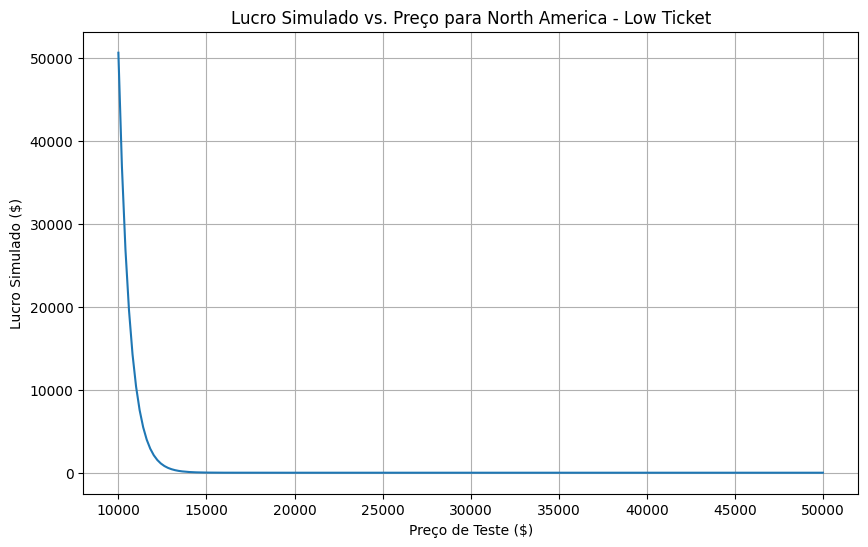

In [ ]:
import matplotlib.pyplot as plt

# Pegue um cenário típico do seu dataset
# Por exemplo, uma campanha na North America para Low Ticket
region = 'North America'
clicks = df[df['Region'] == region]['Clicks'].mean()
metrics = region_metrics.get(region)
elasticity = elasticity_factors.get(region)
tier_props = product_tiers['High Ticket']

# Crie uma faixa de preços para testar
test_prices = np.linspace(tier_props["min_price"], tier_props["max_price"], 200)
simulated_profits = []

for price in test_prices:
    base_conv_rate = metrics['avg_conversion_rate'] * tier_props["conv_rate_multiplier"]
    sim_conv_rate = base_conv_rate * np.exp(-elasticity * (price - tier_props["min_price"]))
    sim_conv_rate = max(0, sim_conv_rate)
    sim_conversions = clicks * sim_conv_rate
    sim_revenue = sim_conversions * price
    sim_marketing_cost = sim_conversions * metrics['avg_cpa']
    profit = sim_revenue - sim_marketing_cost
    simulated_profits.append(profit)

# Plotar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(test_prices, simulated_profits)
plt.title(f'Lucro Simulado vs. Preço para {region} - {list(product_tiers.keys())[0]}')
plt.xlabel("Preço de Teste ($)")
plt.ylabel("Lucro Simulado ($)")
plt.grid(True)
plt.show()# conjunto representativo de estado

In [ ]:
# --- Capítulo 9: Comparação com Aprendizado Supervisionado (SL-Regressor) ---

print("\n--- Etapa 9.1: Gerando dataset SINTÉTICO (Preços Discretos) para SL ---")

# Verifica se as métricas do simulador (da Etapa 3) existem
if 'region_metrics' not in locals() or 'elasticity_factors' not in locals():
    raise ValueError("ERRO: 'region_metrics' ou 'elasticity_factors' não definidos. Execute a Etapa 3 primeiro.")

# Lista de preços DISCRETOS que este modelo SL testará
price_points = [29.99, 49.99, 79.99, 99.99, 149.99, 199.99]
generated_data_sl = [] # Nova lista para dados SL

# Itera sobre o DataFrame ORIGINAL 'df' (da Etapa 2)
for _, row in df.iterrows():
    region = row['Region']
    metrics = region_metrics.get(region)
    if not metrics: continue

    elasticity = elasticity_factors.get(region, 0.015)

    # Para cada linha do df, simula o lucro para cada um dos 6 preços fixos
    for price in price_points:
        # Lógica de simulação (simplificada do seu notebook SL)
        # Nota: A fórmula aqui é ligeiramente diferente da Etapa 3 do RL (ex: 'price - 50' vs 'price - price_reference')
        # Idealmente, as lógicas do simulador deveriam ser idênticas.
        # Vamos manter a lógica original do seu notebook SL:

        simulated_conversion_rate = metrics['avg_conversion_rate'] * np.exp(-elasticity * (price - 50)) # Ref '50' do notebook SL
        simulated_conversion_rate = max(0, simulated_conversion_rate)
        simulated_conversions = row['Clicks'] * simulated_conversion_rate
        simulated_revenue = simulated_conversions * price
        simulated_marketing_cost = simulated_conversions * metrics['avg_cpa']
        simulated_profit = simulated_revenue - simulated_marketing_cost

        # Adiciona o resultado (Estado + Ação + Recompensa)
        generated_data_sl.append({
            'Region': region,
            'Content_Type': row['Content_Type'],
            'Target_Age': row['Target_Age'],
            'Target_Gender': row['Target_Gender'],
            'Platform': row['Platform'],
            'Budget': row['Budget_Category'],
            'Price_Action': price, # O preço é uma FEATURE
            'Simulated_Profit_Reward': simulated_profit # O lucro é o ALVO
        })

# Cria o DataFrame de treino do SL
df_sl_training = pd.DataFrame(generated_data_sl)
df_sl_training.dropna(inplace=True)
print(f"Dataset para Supervised Learning gerado com {len(df_sl_training)} linhas.")


--- Etapa 9.1: Gerando dataset SINTÉTICO (Preços Discretos) para SL ---
Dataset para Supervised Learning gerado com 6000 linhas.


In [ ]:
# --- Etapa 10: Formatando dados para o modelo de SL (Regressão) ---
print("\n--- Etapa 10: Formatando dados para o modelo de SL ---")

# Importações necessárias para SL
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define o alvo (y) = Lucro
y_sl = df_sl_training['Simulated_Profit_Reward']
# Define as features (X) = Estado + Ação (Preço)
X_sl_temp = df_sl_training.drop('Simulated_Profit_Reward', axis=1)

# One-Hot Encoding para as features de estado categóricas
# 'Price_Action' é mantida como numérica, pois é uma feature
X_sl = pd.get_dummies(X_sl_temp, columns=['Region', 'Content_Type', 'Target_Age', 'Target_Gender', 'Platform', 'Budget'])

# Divide os dados SL em treino e teste
X_train_sl, X_test_sl, y_train_sl, y_test_sl = train_test_split(X_sl, y_sl, test_size=0.2, random_state=42)

print(f"Dados SL divididos em {len(X_train_sl)} para treino e {len(X_test_sl)} para teste.")
print("Features SL de exemplo:\n", X_train_sl.head(1))


--- Etapa 10: Formatando dados para o modelo de SL ---
Dados SL divididos em 4800 para treino e 1200 para teste.
Features SL de exemplo:
       Price_Action  Region_Africa  Region_Asia  Region_Europe  \
3897         99.99          False        False          False   

      Region_North America  Region_South America  Content_Type_Carousel  \
3897                 False                  True                  False   

      Content_Type_Image  Content_Type_Text  Content_Type_Video  ...  \
3897                True              False               False  ...   

      Target_Gender_Male  Target_Gender_Other  Platform_Facebook  \
3897               False                 True              False   

      Platform_Google  Platform_Instagram  Platform_LinkedIn  \
3897            False               False               True   

      Platform_YouTube  Budget_Alto  Budget_Baixo  Budget_Médio  
3897             False        False          True         False  

[1 rows x 26 columns]


In [ ]:
# --- Etapa 11: Treinando o modelo LightGBM para PREVER O LUCRO ---
print("\n--- Etapa 11: Treinando o modelo LightGBM para prever o lucro ---")

# Instancia o REGRESSOR LightGBM
lgbm_regressor = lgb.LGBMRegressor(random_state=42)

# Treina o modelo para aprender a mapear (Estado, Preço) -> Lucro
lgbm_regressor.fit(X_train_sl, y_train_sl)

print("Modelo SL (Regressor) treinado com sucesso!")


--- Etapa 11: Treinando o modelo LightGBM para prever o lucro ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 26
[LightGBM] [Info] Start training from score 13351.779761
Modelo SL (Regressor) treinado com sucesso!


In [ ]:
# --- Etapa 12: Avaliando a PRECISÃO do modelo SL no conjunto de teste ---
print("\n--- Etapa 12: Avaliando a precisão do modelo SL no conjunto de teste ---")

# Faz previsões de lucro no conjunto de teste SL
y_pred_sl = lgbm_regressor.predict(X_test_sl)

# Calcula métricas de precisão da regressão
mae = mean_absolute_error(y_test_sl, y_pred_sl)
mse = mean_squared_error(y_test_sl, y_pred_sl)
r2 = r2_score(y_test_sl, y_pred_sl)

print(f"----------- MÉTRICAS DE PRECISÃO (Regressão do Lucro) -----------\n")
print(f"Erro Médio Absoluto (MAE): ${mae:,.2f}")
print(f"Erro Quadrático Médio (MSE): {mse:,.2f}")
print(f"R-quadrado (R²): {r2:.2%}")
print("----------------------------------------------------------------")
print("\n- MAE: Em média, as previsões de lucro do modelo SL erram por este valor.")
print("- R²: O modelo SL consegue explicar esta porcentagem da variação no lucro simulado.")


--- Etapa 12: Avaliando a precisão do modelo SL no conjunto de teste ---
----------- MÉTRICAS DE PRECISÃO (Regressão do Lucro) -----------

Erro Médio Absoluto (MAE): $6,403.19
Erro Quadrático Médio (MSE): 92,858,435.35
R-quadrado (R²): 64.27%
----------------------------------------------------------------

- MAE: Em média, as previsões de lucro do modelo SL erram por este valor.
- R²: O modelo SL consegue explicar esta porcentagem da variação no lucro simulado.


In [ ]:
# --- Etapa 13: Avaliação da ESTRATÉGIA de precificação SL (Comparação) ---
print("\n--- Etapa 13: Avaliando o desempenho financeiro da estratégia SL ---")

# Função de otimização: testa todos os 6 preços e escolhe o melhor
def get_optimal_price_sl(scenario, model, prices_to_test, original_cols):
    scenario_df = pd.DataFrame([scenario])
    best_price = None
    max_profit = -np.inf

    # Para cada preço possível...
    for price in prices_to_test:
        scenario_df['Price_Action'] = price
        # Prepara o cenário para o modelo
        scenario_onehot = pd.get_dummies(scenario_df)
        scenario_aligned = scenario_onehot.reindex(columns=original_cols, fill_value=0)

        # Usa o modelo treinado para PREVER o lucro
        predicted_profit = model.predict(scenario_aligned)[0]

        # Encontra o preço que dá o maior lucro previsto
        if predicted_profit > max_profit:
            max_profit = predicted_profit
            best_price = price

    return best_price, max_profit

# --- Avaliação Financeira da Política SL ---

# 1. Pega os dados de TESTE *antes* do one-hot encoding
test_data_original_sl = df_sl_training.loc[X_test_sl.index]

# 2. Define as colunas do cenário
scenario_cols = ['Region', 'Content_Type', 'Target_Age', 'Target_Gender', 'Platform', 'Budget']

# 3. Pega os cenários únicos do conjunto de teste
unique_scenarios_sl = test_data_original_sl[scenario_cols].drop_duplicates().to_dict('records')
print(f"Avaliando a estratégia SL em {len(unique_scenarios_sl)} cenários únicos do conjunto de teste...")

# 4. Cria um "mapa da verdade" com o lucro real (simulado) para cada (cenário, preço)
profit_map_sl = test_data_original_sl.set_index(scenario_cols + ['Price_Action'])['Simulated_Profit_Reward'].to_dict()

total_profit_sl = 0
n_scenarios_sl = len(unique_scenarios_sl)

# 5. Itera sobre cada cenário único
for scenario in unique_scenarios_sl:
    # Pergunta ao modelo SL qual é o melhor preço (dos 6 disponíveis)
    best_price_sl, _ = get_optimal_price_sl(scenario, lgbm_regressor, price_points, X_train_sl.columns)

    # Cria a chave para buscar o lucro real (simulado)
    scenario_key_tuple = tuple(scenario[col] for col in scenario_cols)
    full_key = scenario_key_tuple + (best_price_sl,)

    # Busca o lucro real (simulado) para o preço que o modelo escolheu
    realized_profit = profit_map_sl.get(full_key)

    if realized_profit is not None:
        total_profit_sl += realized_profit

# Calcula o lucro médio por decisão
average_profit_sl = total_profit_sl / n_scenarios_sl if n_scenarios_sl > 0 else 0

print(f"\n----------- RESULTADO DA AVALIAÇÃO DA ESTRATÉGIA SL -----------")
print(f"Lucro médio por decisão seguindo a política do SL: ${average_profit_sl:,.2f}")
print("---------------------------------------------------------------")


--- Etapa 13: Avaliando o desempenho financeiro da estratégia SL ---
Avaliando a estratégia SL em 650 cenários únicos do conjunto de teste...

----------- RESULTADO DA AVALIAÇÃO DA ESTRATÉGIA SL -----------
Lucro médio por decisão seguindo a política do SL: $10,279.92
---------------------------------------------------------------


In [ ]:
# --- Etapa 5: Chamar o LLM para Gerar o Conteúdo (v23 - Teste Simplificado) ---
'''import google.generativeai as genai # Garante que está importado aqui também
from google.generativeai.types import HarmCategory, HarmBlockThreshold # Para configurações de segurança

# Verifica se a chave foi carregada com sucesso ANTES de tentar usar
if GOOGLE_API_KEY:
    try:
        # Usa um modelo recente e disponível
        model_llm = genai.GenerativeModel('gemini-1.5-flash-latest')
        print("\\n--- Chamando o LLM para gerar o conteúdo (chamada simplificada)... ---")

        # --- TENTATIVA DE CORREÇÃO ---
        # 1. Remover o generation_config explícito por agora
        # 2. Adicionar safety_settings básicos para permitir mais conteúdo (APENAS PARA TESTE)
        safety_settings_for_test = {
            HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
            HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
            HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
            HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
        }

        # Faz a chamada à API simplificada
        response = model_llm.generate_content(
            prompt_para_llm,
            safety_settings=safety_settings_for_test # Adiciona as configurações de segurança
            # generation_config removido temporariamente
            )
        # --- FIM DA TENTATIVA DE CORREÇÃO ---
        # Tenta aceder ao texto da resposta
        if response and hasattr(response, 'text'):
             generated_text = response.text
             print("\n--- Conteúdo Gerado pelo LLM ---")
             print(generated_text)
        elif response and response.parts:
             # Às vezes a resposta pode vir em 'parts' se houver bloqueios de segurança
             generated_text = "".join(part.text for part in response.parts)
             print("\n--- Conteúdo Gerado pelo LLM (a partir de 'parts') ---")
             print(generated_text)
             if response.prompt_feedback.block_reason:
                  print(f"\\nAtenção: A resposta pode ter sido bloqueada ou filtrada. Razão: {response.prompt_feedback.block_reason}")
        else:
             print("\\nErro: A resposta da API não continha texto.")
             print("Resposta completa:", response)

    except Exception as e:
      print(f"\n!!! Erro ao chamar a API do LLM: {e} !!!")
      print("   -> Verifique se a API Key é válida.")
      print("   -> Verifique se o nome do modelo ('gemini-1.5-flash-latest') está correto e acessível.")
      print("   -> Verifique a sua conexão à internet.")
      traceback.print_exc()
else:
    # Esta mensagem aparece se o try/except na Etapa 2 falhar
    print("\n!!! A API Key não foi carregada corretamente através dos Secrets. Pulando a chamada ao LLM. !!!")
    print("   -> Verifique as mensagens de erro na Etapa 2 e as instruções para adicionar o Secret.")'''

'import google.generativeai as genai # Garante que está importado aqui também\nfrom google.generativeai.types import HarmCategory, HarmBlockThreshold # Para configurações de segurança\n\n# Verifica se a chave foi carregada com sucesso ANTES de tentar usar\nif GOOGLE_API_KEY:\n    try:\n        # Usa um modelo recente e disponível\n        model_llm = genai.GenerativeModel(\'gemini-1.5-flash-latest\')\n        print("\\n--- Chamando o LLM para gerar o conteúdo (chamada simplificada)... ---")\n\n        # --- TENTATIVA DE CORREÇÃO ---\n        # 1. Remover o generation_config explícito por agora\n        # 2. Adicionar safety_settings básicos para permitir mais conteúdo (APENAS PARA TESTE)\n        safety_settings_for_test = {\n            HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,\n            HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,\n            HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,\n       

In [ ]:
# --- Etapa 14: Salvando o Modelo e Componentes ---
import torch
import json

# 1. Salva o modelo treinado (cql_sac_pricer_iqn)
# (Use o método de save específico do d3rlpy)
if 'cql_sac_pricer_iqn' in locals() and cql_sac_pricer_iqn is not None:
    try:
        cql_sac_pricer_iqn.save_model('modelo_rl_final.pt')
        print("Modelo salvo como 'modelo_rl_final.pt'")
    except Exception as e:
        print(f"Erro ao salvar modelo: {e}")

# 2. Salva a lista de colunas de observação (ESSENCIAL)
# (Esta variável 'observation_cols' foi criada na sua Etapa 4)
if 'observation_cols' in locals():
    with open('colunas_observacao.json', 'w') as f:
        json.dump(observation_cols, f)
    print("Colunas de observação salvas como 'colunas_observacao.json'")

# 3. Salva os 'bins' e 'labels' do orçamento (da Etapa 2)
if 'bins' in locals() and 'labels' in locals():
    budget_config = {
        'bins': bins,
        'labels': labels
    }
    with open('config_orcamento.json', 'w') as f:
        json.dump(budget_config, f)
    print("Configuração de orçamento salva como 'config_orcamento.json'")

Modelo salvo como 'modelo_rl_final.pt'
Colunas de observação salvas como 'colunas_observacao.json'
Configuração de orçamento salva como 'config_orcamento.json'


In [ ]:
import json

print("Iniciando o salvamento dos arquivos...")

# 1. Salva o modelo de RL treinado (necessário d3rlpy, não torch)
try:
    cql_sac_pricer_iqn.save_model('modelo_rl_final.pt')
    print("SUCESSO: Modelo salvo como 'modelo_rl_final.pt'")
except Exception as e:
    print(f"!!! ERRO ao salvar modelo: {e} !!!")

# 2. Salva as colunas de observação
with open('colunas_observacao.json', 'w') as f:
    json.dump(observation_cols, f)
print("SUCESSO: Colunas salvas como 'colunas_observacao.json'")

# 3. Salva as configurações de orçamento
budget_config = {
    'bins': bins,
    'labels': labels
}
with open('config_orcamento.json', 'w') as f:
    json.dump(budget_config, f)
print("SUCESSO: Configuração de orçamento salva como 'config_orcamento.json'")

print("--- Processo de salvamento concluído ---")


Iniciando o salvamento dos arquivos...
SUCESSO: Modelo salvo como 'modelo_rl_final.pt'
SUCESSO: Colunas salvas como 'colunas_observacao.json'
SUCESSO: Configuração de orçamento salva como 'config_orcamento.json'
--- Processo de salvamento concluído ---


In [ ]:
import d3rlpy
print("d3rlpy:", d3rlpy.__version__)


d3rlpy: 2.8.1


In [ ]:
import torch
print("torch:", torch.__version__)

torch: 2.8.0+cu126
